In [1]:
# Libraries needed for data processsing and regression
import pathlib
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.optimize import curve_fit
from sympy import *

# plotting config
%matplotlib inline
sns.set_style("ticks")
sns.set_context('talk', font_scale=1.0)

# turn on and off csv and png file outputs of the model fitting at the end of runtime
# True - enable outputs; False - disable outputs
generate_output = True

In [2]:
# current working directory
cwd = pathlib.Path().resolve()
print(cwd)
data_folder = pathlib.Path(cwd)

C:\Users\ssadm\Downloads\SWV Transients Data


In [3]:
# Names of all data files
# Keep a csv file with the names of all the files in working directory
# data_names_list has the names of all the data files 
file = open(data_folder / 'Files names.csv', "r")
data_names_list = list(csv.reader(file))
file.close()

# fixing weirdness with how single column csv files are read
templist = []
for i in range(len(data_names_list)):
    templist += data_names_list[i]
data_names_list = templist
print(data_names_list) 

['NN 0.1uMTP 1uM BC', 'NN 1.25uMTP 1uM BC', 'NN 1.25uMTP 100nM BC', 'NN 2.5uMTP 100nM BC', 'NN 5uMTP 1uM BC', 'NN 5uMTP 100nM BC', 'NN 10uMTP 1uM BC', 'Planar 0.1uMTP 1uM BC', 'Planar 0.1uMTP 100nM BC', 'Planar 0.5uMTP 1uM BC', 'Planar 0.5uMTP 100nM BC', 'Planar 1uMTP 1uM BC', 'Planar 1uMTP 10nM BC', 'Planar 1uMTP 100nM BC', 'Planar 5uMTP 1uM BC']


In [4]:
# Reading all of the data from csv files
# Putting them list of DataFrames containing SWV Peak Current Data
# data_names_list contains name strings correspodning to data_list
data_list = []        
for i in range(len(data_names_list)):
    df = pd.read_csv(data_folder / (data_names_list[i] + '.csv'))
    data_list.append(df)

## Ligand Binding Kinetics - 1st Order Transient Response

### The mechanism for the basic target-ligand interaction is:


#### R - Receptor; L - Ligand; k1 - association rate constant; k2 - disassoication rate constant



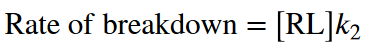

### Rate of Change Equation - change in bound target
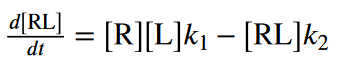

### Conservation of mass provides several more relations
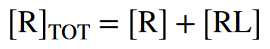

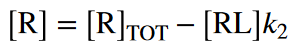


#### R_ToT - total receptor conc.; B_max - equal to R_ToT in relation to surface binding sites

### Substitutions into the rate of change equation


### Solving the differential equation for time-domain response


### My modified version
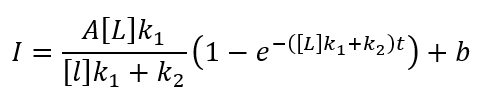
#### I - Peak Current [uA]; A - Sensitivity [uA/uM]; b - baseline current [uA]

### What this response looks like
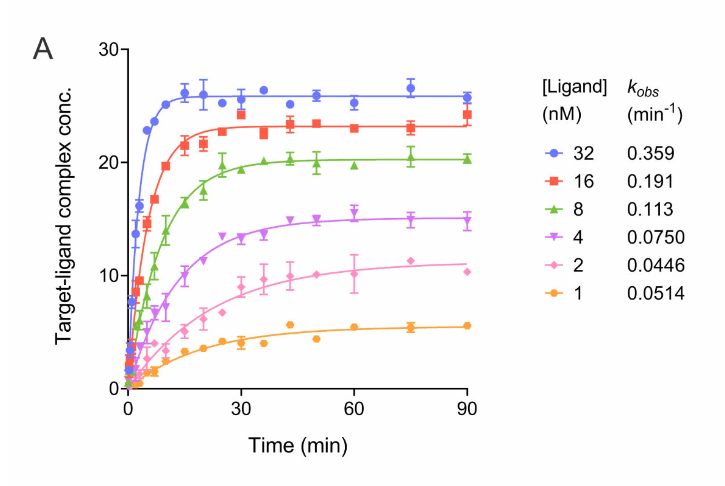

## Ligand Binding Kinetics - 2nd Order Transient Response

### What Enas' data looks like:
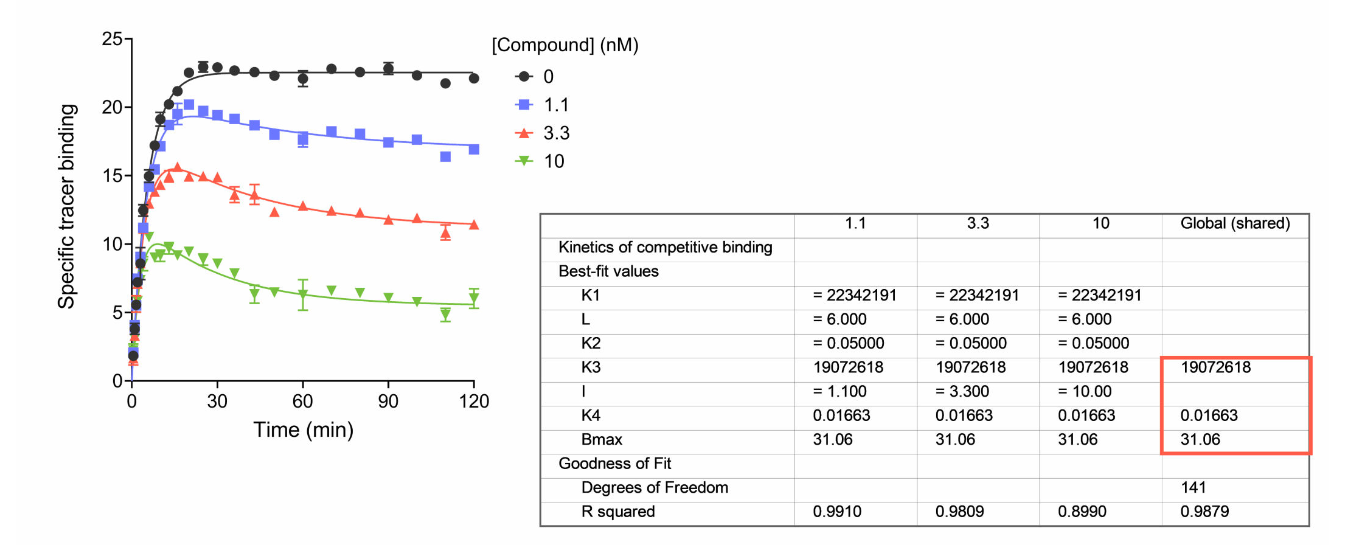
#### Overshoot is a key feature in all the data

#### Classic 2nd order underdamped response - osscillatory behavior

### The mechanism for Combetitive binding kinetics
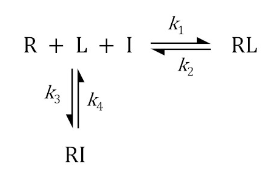
#### R - Receptor; L - Target Ligand; I - non-specfic Ligand; 
#### k1 and k3 - association rate constant for; k2 and k4- disassoication rate constant; 

### Transient response after solving differential equation describing competitive binding

#### Note that K_F, K_S, K_A and K_B are composite paramaters to simplify above equation

### My modified version
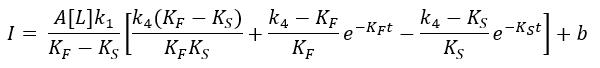

In [5]:
%%capture          

# plotting all the data and saving them as figure objects
# plots are prevented from displaying due to the above inline command
# data_plots contains the the list of figure objects
# data_plots is related to data_list and data_names_list in that it contains the corresponding plots
data_plots = []
for i in range(len(data_names_list)):
    data_plot = sns.relplot(
        data=data_list[i], kind="scatter",
        x="Time", y="Peak Current",
    )
    
    data_plot.set(title=data_names_list[i])
    data_plot.set_axis_labels("Time (min)", "Peak Current (µA)", labelpad=10)
    data_plot.figure.set_size_inches(6.0, 6.0)
    #data_plot.ax.margins(.15)
    #data_plot.despine(trim=True)
    
    data_plots.append(data_plot)
    
# data_plots[4].fig

In [6]:
# First-order transient response model
# lig_C is a global variable used to pass probe concentration values to the model, as that isn'tt a variable being solved for
def first_time_response(x, A, k_1, k_2, b):
    y = (((A*lig_C*k_1)/((lig_C*k_1)+k_2))*(1-np.exp(-1*((lig_C*k_1)+k_2)*x)))+b
    return y

# returns Jacobian of the first-order transient function
def one_jac(x, A, k_1, k_2, b):
    x, A, k_1, k_2, b = symbols("x A k_1 k_2 b")
    y = (((A*lig_C*k_1)/((lig_C*k_1)+k_2))*(1-exp(-1*((lig_C*k_1)+k_2)*x)))+b
    return np.array([diff(y, A), diff(y, k_1), diff(y, k_2), diff(y, b)]).T

In [7]:
# First-order transient response model
# lig_C is a global variable used to pass probe concentration values to the model, as that isn'tt a variable being solved for
# lig_I is concentration of third non-specific variable - not a global variable - model is optimizing for this variable
def second_time_response(x, A, k_1, k_2, k_3, k_4, lig_I, b):
    
    # composite coefficient 
    K_A = (lig_C*k_1)+k_2
    K_B = (lig_I*k_3)+k_4
    
    K_F = 0.5*(K_A+K_B+math.sqrt(((K_A-K_B)**2)+(4*lig_C*lig_I*k_1*k_3)))
    K_S = 0.5*(K_A+K_B-math.sqrt(((K_A-K_B)**2)+(4*lig_C*lig_I*k_1*k_3)))
    
    # composite terms within the equation
    # this is a very long equation that is easy to make mistakes on
    steady_state = (A*lig_C*k_1)/(K_F-K_S)
    term1 = (k_4*(K_F-K_S))/(K_F*K_S)
    term2 = ((k_4-K_F)/K_F)*np.exp(-1*K_F*x)
    term3 = ((k_4-K_S)/K_S)*np.exp(-1*K_S*x)
    
    # The actual equation
    y = steady_state*(term1+term2-term3)+b
    return y

# returns Jacobian of the second-order transient function
def two_jac(x, A, k_1, k_2, k_3, k_4, lig_I, b):
    x, A, k_1, k_2, k_3, k_4, lig_I, b = symbols("x A k_1 k_2 k_3 k_4 lig_I b")
    
    # composite coefficient 
    K_A = (lig_C*k_1)+k_2
    K_B = (lig_I*k_3)+k_4
    
    K_F = 0.5*(K_A+K_B+sqrt(((K_A-K_B)**2)+(4*lig_C*lig_I*k_1*k_3)))
    K_S = 0.5*(K_A+K_B-sqrt(((K_A-K_B)**2)+(4*lig_C*lig_I*k_1*k_3)))
    
    # composite terms within the equation
    # this is a very long equation that is easy to make mistakes on
    steady_state = (A*lig_C*k_1)/(K_F-K_S)
    term1 = (k_4*(K_F-K_S))/(K_F*K_S)
    term2 = ((k_4-K_F)/K_F)*exp(-1*K_F*x)
    term3 = ((k_4-K_S)/K_S)*exp(-1*K_S*x)
    
    # The actual equation
    y = steady_state*(term1+term2-term3)+b
    
    return np.array([diff(y, A), diff(y, k_1), diff(y, k_2), diff(y, k_3), diff(y, k_4), diff(y, lig_I), diff(y, b)]).T

In [8]:
# Extracts target concentration value from file name
# returns target concentration in µM
def get_lig_C(data_name):
    
    # Extracting the value and SI multiplier from the third word in the title
    target_conc = data_name.split() 
    value = float(target_conc[2][:-2])
    SI_symbol = target_conc[2][-2]
    
    possible_SI_symbol = ["m", "u", "n", "p"] # micro needs to be 'u'
    possible_SI_mult = [1000, 1, 0.001, 0.000001]
    
    # since function returns value in uM, value is adjusted based on SI symbol in title
    for i in range(len(possible_SI_symbol)):
        if possible_SI_symbol[i] == SI_symbol:
            return value*possible_SI_mult[i]
        else:
            continue
            
    return

In [9]:
# Initial predictions for the two models
# 1st order model parameters
one_A = 0.45
one_k_1 = 10000
one_k_2 = 0.5
one_b = 0.4
# 2nd order model parameters
two_A = 2.47828412
two_k_1 = 0.21350722
two_k_2 = 0.89478663
two_k_3 = 5.68729447
two_k_4 = 0.0267102
two_lig_I = 0.01969618
two_b = 0.45017234

i = 13

# target concnentration extracted from file name
lig_C = get_lig_C(data_names_list[i])

y1_pred = first_time_response(data_list[i]["Time"].values, one_A, one_k_1, one_k_2, one_b)
y2_pred = second_time_response(data_list[i]["Time"].values, two_A, two_k_1, two_k_2, two_k_3, two_k_4, two_lig_I, two_b)
data_list[i].insert(2, "y1_pred", y1_pred, True)
data_list[i].insert(3, "y2_pred", y2_pred, True)

# fitting the data
one_popt, one_pcov = curve_fit(
    f = first_time_response,
    xdata = data_list[i]["Time"].values,
    ydata = data_list[i]["Peak Current"].values,
    p0 = [one_A, one_k_1, one_k_2, one_b],
    bounds = (0, np.inf),
    maxfev = 500000,
)
two_popt, two_pcov = curve_fit(
    f = second_time_response, 
    xdata = data_list[i]["Time"].values, 
    ydata = data_list[i]["Peak Current"].values,
    p0 = [two_A, two_k_1, two_k_2, two_k_3, two_k_4, two_lig_I, two_b],
    bounds = (0, np.inf),
    maxfev = 500000,
)
y1_model = first_time_response(data_list[i]["Time"].values, *one_popt)
y2_model = second_time_response(data_list[i]["Time"].values, *two_popt)
data_list[i].insert(4, "y1_model", y1_model, True)
data_list[i].insert(5, "y2_model", y2_model, True)

# plotting original measurements as scatter plot with model fittings
# green is first order fitting
# red is second order fitting
fig, ax = plt.subplots(figsize=(6, 6))
p1 = sns.scatterplot(data=data_list[i], x="Time", y="Peak Current", ax=ax)
p2 = sns.lineplot(data=data_list[i], x="Time", y="y2_pred", color="green", ax=ax)
p3 = sns.lineplot(data=data_list[i], x="Time", y="y2_model", color="red", ax=ax)
fig.suptitle(data_names_list[i], fontsize=18)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Peak Current (µA)")
plt.savefig(data_names_list[i]+".png", dpi=300)

print(data_names_list[i])
print(two_popt)

# saves fitted values to csv alongside the original values 
# save as csv file separated by tabs
if generate_output:
    data_list[i].to_csv(data_names_list[i]+"_MODEL.csv", sep=',', encoding='utf-8')

Planar 1uMTP 100nM BC
[3.68906956e+00 1.17069170e-01 8.56335028e-04 8.71667526e-04
 5.61661867e+01 2.06525424e-04 1.88175063e-35]
